# YCoCg image quantization

Removing color redundancy with the YCoCg transform. [YCrCb image quantization](https://github.com/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/06-YUV_quantization/YCrCb_quantization.ipynb) should be read first.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os
!ln -sf ~/quantization/deadzone_quantizer.py .
!ln -sf ~/quantization/midtread_quantizer.py .
!ln -sf ~/quantization/distortion.py .
!ln -sf ~/quantization/information.py .
!ln -sf ~/MRVC/src/YCoCg.py .
!ln -sf ~/MRVC/src/debug.py
!ln -sf ~/MRVC/src/image_3.py
!ln -sf ~/MRVC/src/image_1.py
!ln -sf ../common.py .
import deadzone_quantizer as Q
#import YCrCb
import YCoCg
import distortion
import information
import image_3 as RGB_image
import image_1 as gray_image
import colored
import common

## Configuration

In [2]:
# Prefix of the RGB image to be quantized.

HOME = os.environ["HOME"]
#fn = HOME + "/MRVC/sequences/stockholm/"
fn = HOME + "/MRVC/sequences/lena_color/"
image_dtype = np.uint8 # For 8 bpp/component images
#image_dtype = np.uint16 # For 16 bpp/component images

YCoCg_components = ['Y', 'Co', 'Cg']

# Number of quantization steps.
Q_steps = 8
#Q_steps = [256*i/N_Q_steps for i in range(N_Q_steps + 1, 0, -1)]
Q_steps = [2**i for i in range(7, -1, -1)]
print(Q_steps)

#quantizer = midtread
#quantizer = deadzone
#quantizer = midrise

[128, 64, 32, 16, 8, 4, 2, 1]


## Read the image and show it

image_3.read: /home/vruiz/MRVC/sequences/lena_color/000.png (512, 512, 3) uint8 512673 


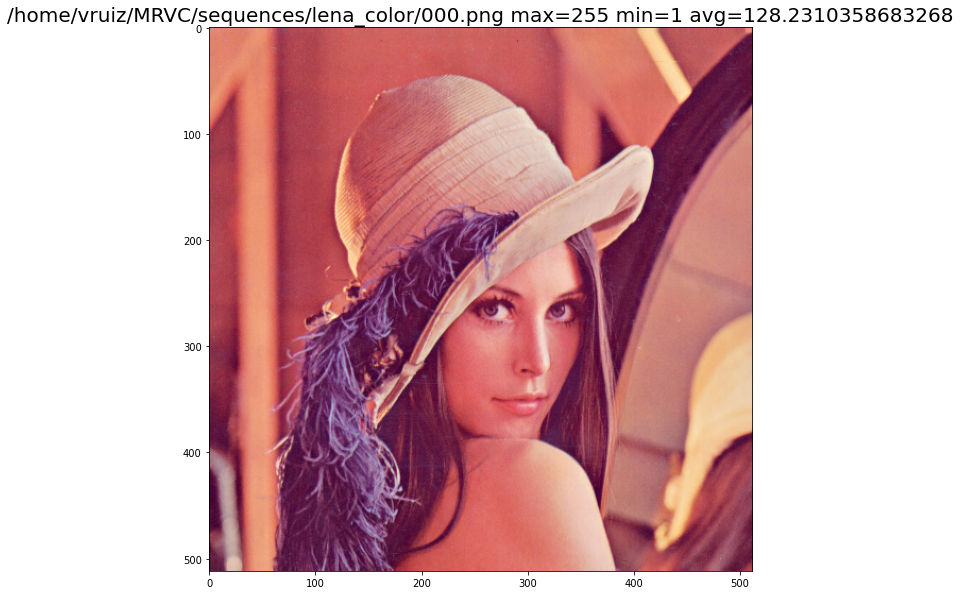

In [3]:
RGB_img = RGB_image.read(fn).astype(image_dtype)
common.show(RGB_img, fn + "000.png")

In [4]:
RGB_img.shape

(512, 512, 3)

In [5]:
RGB_img.dtype

dtype('uint8')

## (RGB <-> YCoCg) transform of the image

In [6]:
YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
print(YCoCg_img.dtype)
Y_img = YCoCg_img[...,0]
Co_img = YCoCg_img[...,1]
Cg_img = YCoCg_img[...,2]

int16


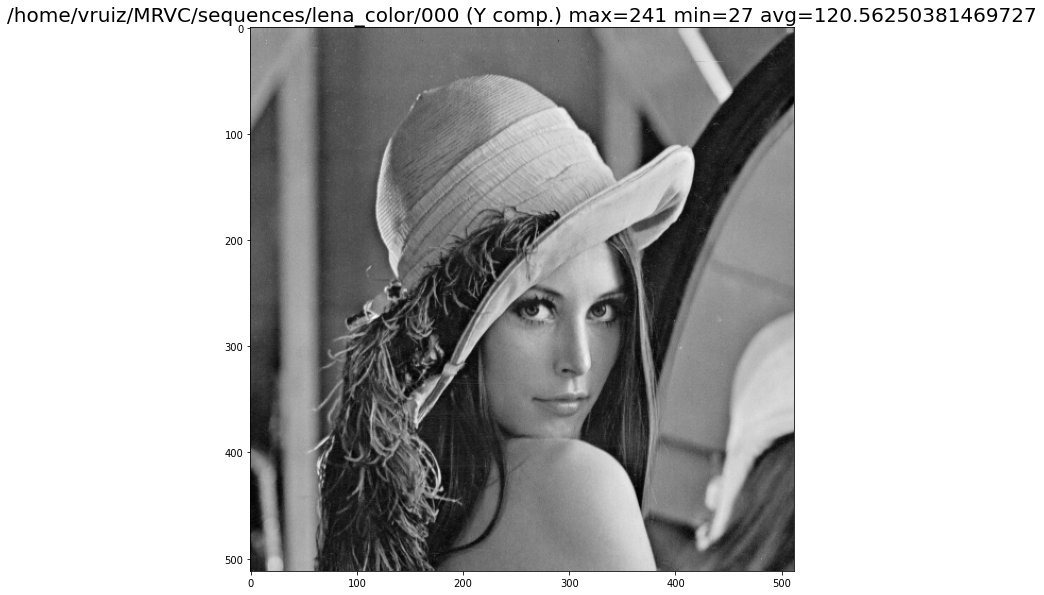

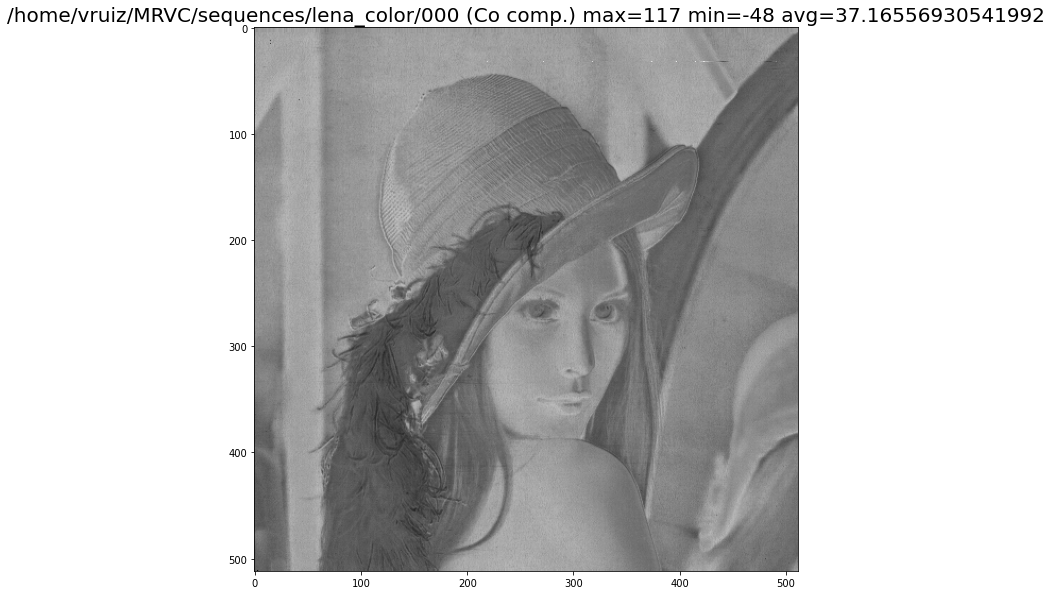

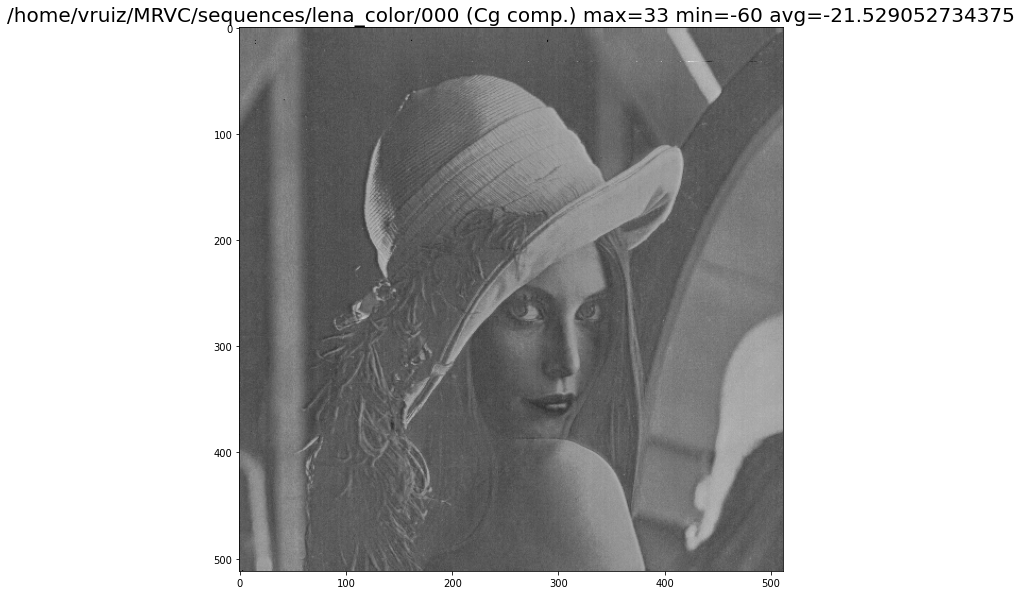

In [7]:
common.show_gray(Y_img, fn + "000 (Y comp.)")
common.show_gray(Co_img, fn + "000 (Co comp.)")
common.show_gray(Cg_img, fn + "000 (Cg comp.)")

The Y component is always positive, but the chromas can be positive and negative. 

## Energy of the YCoCg channels

In [8]:
Y_avg_energy = information.average_energy(Y_img)
Co_avg_energy = information.average_energy(Co_img)
Cg_avg_energy = information.average_energy(Cg_img)
print("Energy of Y =", int(Y_avg_energy))
print("Energy of Co =", int(Co_avg_energy))
print("Energy of Cg =", int(Cg_avg_energy))
total_YCoCg_avg_energy = Y_avg_energy + Co_avg_energy + Cg_avg_energy
print(f"Total average energy (computed by adding the energies of the YCoCg components {int(Y_avg_energy)} + {int(Co_avg_energy)} + {int(Cg_avg_energy)}) = {int(total_YCoCg_avg_energy)}")
print(f"Total RGB average energy (computed directly from the RGB image) = {int(information.average_energy(RGB_img)*3)}")

Energy of Y = 16577
Energy of Co = 1707
Energy of Cg = 546
Total average energy (computed by adding the energies of the YCoCg components 16577 + 1707 + 546) = 18831
Total RGB average energy (computed directly from the RGB image) = 59766


The forward YCoCg transform is not energy preserving. Moreover, the energy is more concentrated in the YCoCg domain, more specifically in the Y channel.

In [9]:
RGB_recons_img = YCoCg.to_RGB(YCoCg_img)
print(f"Total RGB average energy of reconstruction = {int(information.average_energy(RGB_recons_img)*3)}")

Total RGB average energy of reconstruction = 59311


The backward YCoCg is not energy perserving, but the complete pair of transforms (RGB <-> YCoCg) is almost 1-gain.

## (RGB <-> YCoCg) transform error

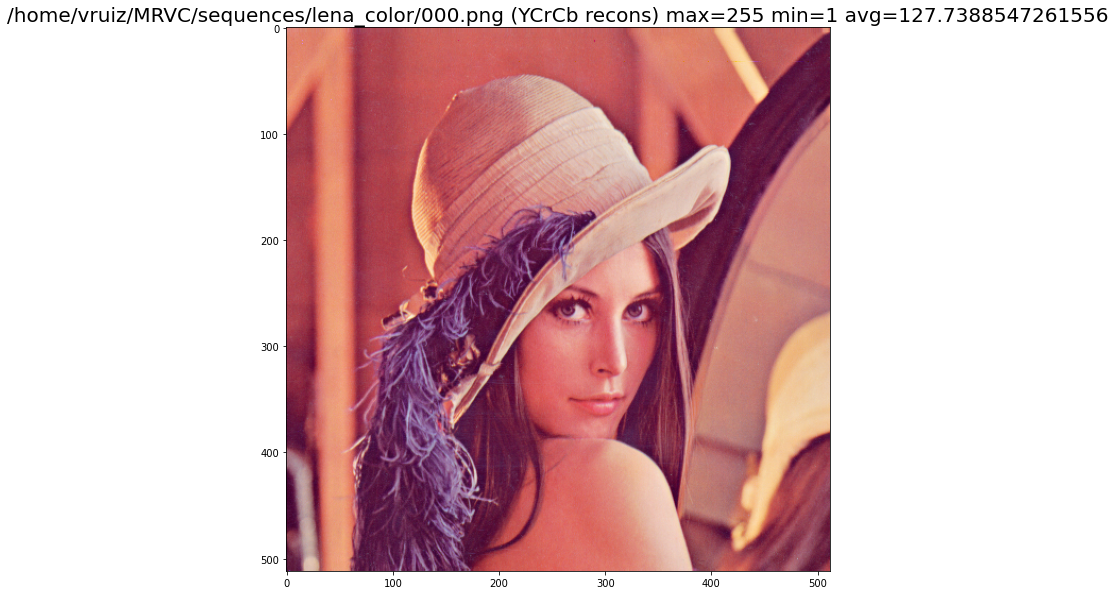

In [10]:
common.show(RGB_recons_img, fn + "000.png (YCrCb recons)")

In [11]:
np.array_equal(RGB_img, RGB_recons_img)

False

In [12]:
print(RGB_img.max(), RGB_img.min(), np.average(RGB_img))

255 1 128.2310358683268


In [13]:
print(RGB_recons_img.max(), RGB_recons_img.min(), np.average(RGB_recons_img))

255 1 127.7388547261556


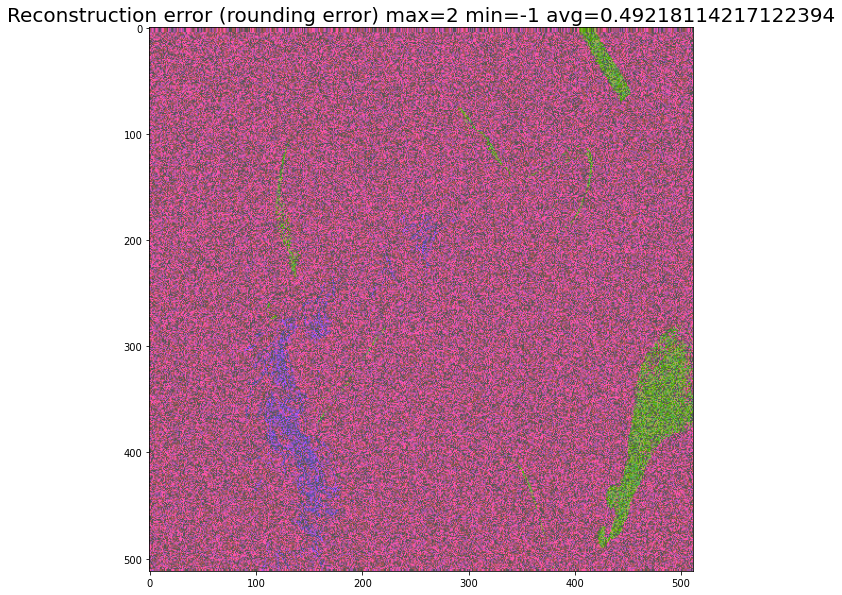

In [14]:
common.show(RGB_img - RGB_recons_img, "Reconstruction error (rounding error)")

Even using integer denominators in the forward transform, the use of floating point arithmetic results in an irreversible transform. 

## Relative gains of the synthesis filters
The quantization step should be adjusted to the synthesis filters gains in order to effectively provide the desired number of [bins](http://www.winlab.rutgers.edu/~crose/322_html/quantization.pdf) (different dequantized values).

In [15]:
val = 30
delta_YCoCg = np.array([val, 0, 0]).reshape(1,1,3)
delta_RGB = YCoCg.to_RGB(delta_YCoCg)
energy_Y = information.average_energy(delta_RGB)
print("delta_YCoCg =", delta_YCoCg, "<-> delta_RGB =", delta_RGB, "=> Y gain =", energy_Y)

delta_YCoCg = np.array([0, val, 0]).reshape(1,1,3)
delta_RGB = YCoCg.to_RGB(delta_YCoCg)
energy_Co = information.average_energy(delta_RGB)
print("delta_YCoCg =", delta_YCoCg, "<-> delta_RGB =", delta_RGB, "=> Cr gain =", energy_Co)

delta_YCoCg = np.array([0, 0, val]).reshape(1,1,3)
delta_RGB = YCoCg.to_RGB(delta_YCoCg)
energy_Cg = information.average_energy(delta_RGB)
print("delta_YCoCg =", delta_YCoCg, "<-> delta_RGB =", delta_RGB, "=> Cb gain =", energy_Cg)

delta_YCoCg = np.array([val, val, val]).reshape(1,1,3)
delta_RGB = YCoCg.to_RGB(delta_YCoCg)
print("delta_YCoCg =", delta_YCoCg, "<-> delta_RGB =", delta_RGB, "=> Total gain =", information.average_energy(delta_RGB))

delta_YCoCg = [[[30  0  0]]] <-> delta_RGB = [[[30 30 30]]] => Y gain = 900.0
delta_YCoCg = [[[ 0 30  0]]] <-> delta_RGB = [[[ 30   0 -30]]] => Cr gain = 600.0
delta_YCoCg = [[[ 0  0 30]]] <-> delta_RGB = [[[-30  30 -30]]] => Cb gain = 900.0
delta_YCoCg = [[[30 30 30]]] <-> delta_RGB = [[[ 30  60 -30]]] => Total gain = 1800.0


In [16]:
print(energy_Y/energy_Co, 3/2)

1.5 1.5


In [17]:
print(energy_Y/energy_Cg, 3/3)

1.0 1.0


With the YCoCg happens the same (the energy of the components is not additive). The gains matches with the theory.

## Amplitude shift in the YCrCb domain

To decide how to quantize, it is necessary to known how the amplitudes the image are *translated* to the transformed domain. A good choice to find out this is to transform electronic noise. In our case, lets use a random image with ([normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)) [Gaussian noise](https://en.wikipedia.org/wiki/Gaussian_noise) with mean 128, YCoCg-it, and check where the transformed noise has its mean. Notice that, by definition, the noise cannot be decorrelated by transforms, and therefore, the noise is simply transfered to the transform domain.

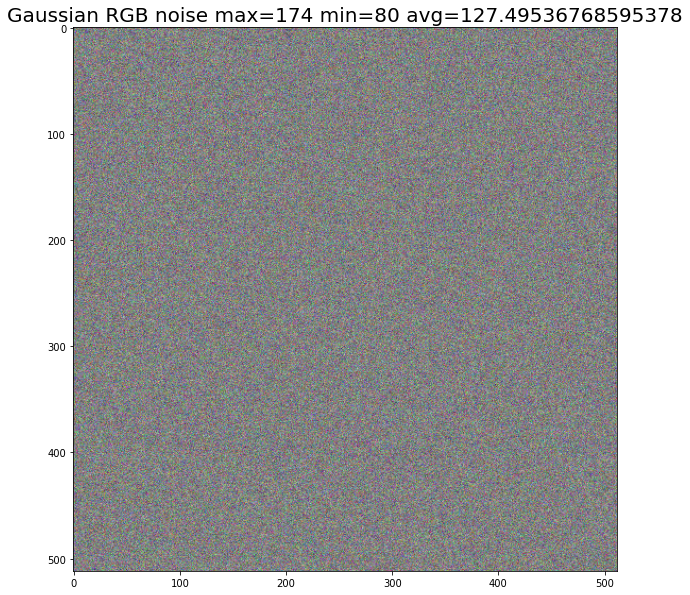

In [18]:
# loc = mean, scale=standard deviation, size=number of samples
RGB_noise = np.random.normal(loc=128, scale=10, size=512*512*3).reshape(512,512,3).astype(np.int16)
common.show(RGB_noise, "Gaussian RGB noise")

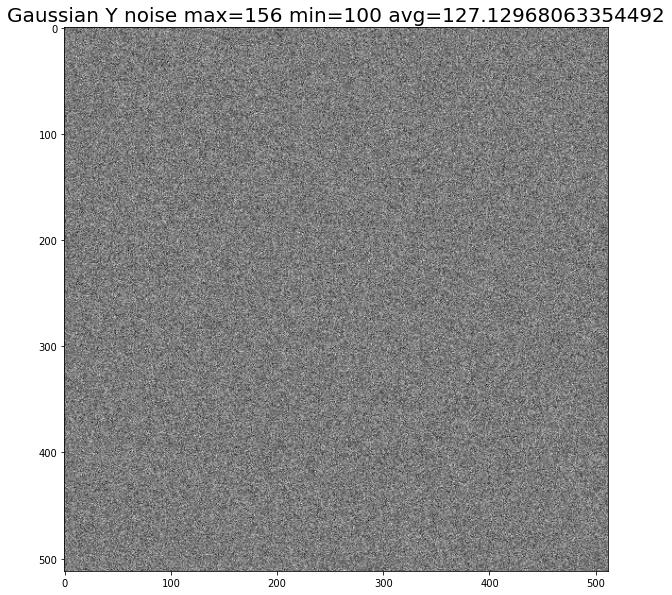

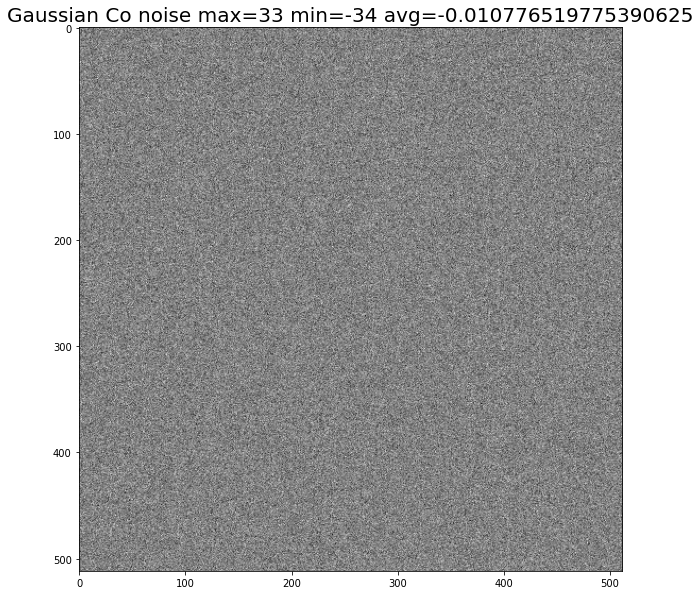

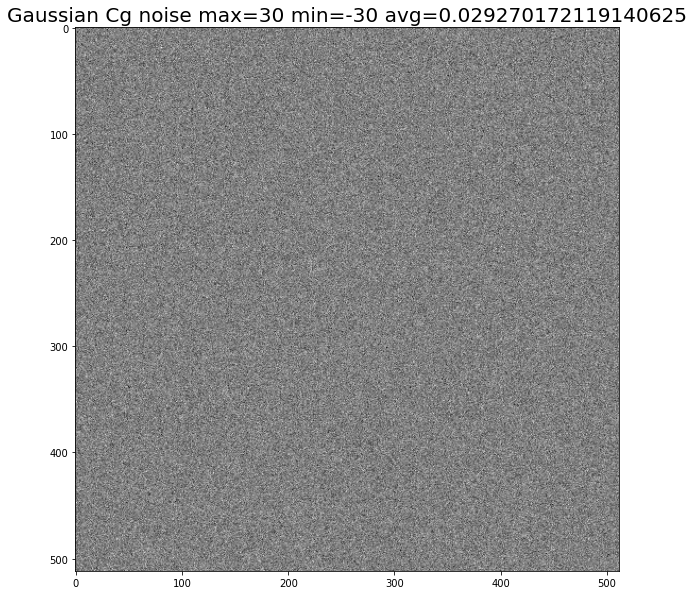

In [19]:
YCoCg_noise = YCoCg.from_RGB(RGB_noise)
common.show_gray(YCoCg_noise[..., 0], "Gaussian Y noise")
common.show_gray(YCoCg_noise[..., 1], "Gaussian Co noise")
common.show_gray(YCoCg_noise[..., 2], "Gaussian Cg noise")

The YCoCg works as the DCT. The chromas are centered at 0.

## Simple quantization in the YCoCg domain ($\frac{3}{2}\Delta_{\text{Y}} = \Delta_{\text{Co}} = \frac{3}{2}\Delta_{\text{Cg}}$)
Although the transform is near orthogonal, we will measure the distortion in the RGB domain.

In [ ]:
def YCoCg_compute_simple_RD_curve(RGB_img, Q_steps, Q):
    relative_Y_gain = 3/2
    relative_Co_gain = 1
    relative_Cg_gain = 3/2

    RGB_img = RGB_img.astype(np.int16)
    avg0 = np.average(RGB_img[..., 0]).astype(np.int16)
    avg1 = np.average(RGB_img[..., 1]).astype(np.int16)
    avg2 = np.average(RGB_img[..., 2]).astype(np.int16)
    RGB_img[..., 0] -= avg0
    RGB_img[..., 1] -= avg1
    RGB_img[..., 2] -= avg2

    YCoCg_img = YCoCg.from_RGB(RGB_img)
    points = []
    common.show(RGB_img,'')
    for Q_step in Q_steps:

        YCoCg_y = np.empty_like(YCoCg_img)
        k = np.empty_like(YCoCg_img, dtype=np.uint8)
        YCoCg_y[...,0], k[...,0] = Q.quan_dequan(YCoCg_img[...,0], (Q_step)/relative_Y_gain)
        YCoCg_y[...,1], k[...,1] = Q.quan_dequan(YCoCg_img[...,1], (Q_step)/relative_Co_gain)
        YCoCg_y[...,2], k[...,2] = Q.quan_dequan(YCoCg_img[...,2], (Q_step)/relative_Cg_gain)

        rate = common.bits_per_color_pixel(k.astype(np.uint8), str(Q_step) + '_')
        RGB_y = YCoCg.to_RGB(YCoCg_y)
        _distortion = distortion.MSE(RGB_img, RGB_y)
        common.show(RGB_y, '')
        points.append((rate, _distortion))
        print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

YCoCg_simple_RD_curve = YCoCg_compute_simple_RD_curve(RGB_img, Q_steps, Q)

def YCoCg_RD_curve(RGB_img):
    RD_points = []
    #for q_step in range(0, 8):
    for Q_step in range(1, 256):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        #k, dequantized_YCoCg_img = q_deq(YCoCg_img, 1<<q_step)
        k, dequantized_YCoCg_img = q_deq(YCoCg_img, Q_step)
        k = k.astype(np.uint8)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_img = YCoCg.to_RGB(dequantized_YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={Q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

#YCoCg_points = YCoCg_RD_curve(img)

relative_Y_gain = 3/2
relative_Co_gain = 1
relative_Cg_gain = 3/2
def YCoCg_RD_curve_with_gains(RGB_img):
    RD_points = []
    #for q_step in range(0, 8):
    for Q_step in range(1, 256):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        dequantized_YCoCg_img = np.empty_like(YCoCg_img)
        k = np.empty_like(YCoCg_img, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_img[:,:,0] = q_deq(YCoCg_img[:,:,0], (Q_step)/relative_Y_gain)
        k[:,:,1], dequantized_YCoCg_img[:,:,1] = q_deq(YCoCg_img[:,:,1], (Q_step)/relative_Co_gain)
        k[:,:,2], dequantized_YCoCg_img[:,:,2] = q_deq(YCoCg_img[:,:,2], (Q_step)/relative_Cg_gain)
        #k[0], dequantized_YCoCg_img[0] = q_deq(YCoCg_img[0], q_step/relative_Y_gain)
        #k[1], dequantized_YCoCg_img[1] = q_deq(YCoCg_img[1], q_step/relative_Co_gain)
        #k[2], dequantized_YCoCg_img[2] = q_deq(YCoCg_img[2], q_step/relative_Cg_gain)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_img = YCoCg.to_RGB(dequantized_YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={Q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

#YCoCg_gains_points = YCoCg_RD_curve_with_gains(img)

## Let's see the RD curve (and compare)

In [ ]:
DCT_points = []
with open(f'./color_DCT.txt', 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        DCT_points.append((float(rate), float(_distortion)))

In [ ]:
# "$\frac{3}{2}\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Co}} = \frac{3}{2}\Delta_{\mathrm{Cg}}$ (Distortion in RGB domain)
pylab.figure(dpi=150)
pylab.plot(*zip(*DCT_points), c='r', marker='.', label="$\Delta_{\mathrm{DCT0}} = \Delta_{\mathrm{DCT1}} = \Delta_{\mathrm{DCT2}}$", linestyle="dashed")
pylab.plot(*zip(*YCoCg_simple_RD_curve), c='b', marker='.', label="$(3/2)\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Co}} = (3/2)\Delta_{\mathrm{Cg}}$", linestyle="dotted")
pylab.title("Rate/Distortion")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE in RGB domain")
pylab.legend(loc='upper right')
pylab.show()

## RD curve of each YCoCg component

In [ ]:
def YCoCg_compute_RD_curve_per_component(RGB_img, Q_steps, Q, components):
    relative_Y_gain = 3/2
    relative_Co_gain = 1
    relative_Cg_gain = 3/2

    RGB_img = RGB_img.astype(np.int16)
    RGB_img[..., 0] -= np.average(RGB_img[..., 0]).astype(np.int16)
    RGB_img[..., 1] -= np.average(RGB_img[..., 1]).astype(np.int16)
    RGB_img[..., 2] -= np.average(RGB_img[..., 2]).astype(np.int16)
    
    YCoCg_img = YCoCg.from_RGB(RGB_img)
    YCoCg_img_copy = YCoCg_img.copy()
    N_components = len(components)
    RD_points = []
    for c in range(N_components):
        RD_points.append([])
    for Q_step in Q_steps:
        k = np.empty_like(YCoCg_img, dtype=np.uint8)
        k[...,0] = Q.quantize(YCoCg_img[...,0], (Q_step)/relative_Y_gain)
        k[...,1] = Q.quantize(YCoCg_img[...,1], (Q_step)/relative_Co_gain)
        k[...,2] = Q.quantize(YCoCg_img[...,2], (Q_step)/relative_Cg_gain)
        YCoCg_k = Q.quantize(YCoCg_img, Q_step)
        for component_index in range(N_components):
            component_name = components[component_index]
            #YCoCg_y = np.zeros_like(YCoCg_img)
            YCoCg_y = YCoCg_img_copy.copy()
            YCoCg_y[..., component_index] = Q.dequantize(YCoCg_k[..., component_index], Q_step)
            rate = common.bits_per_gray_pixel(YCoCg_k[..., component_index], str(Q_step) + '_' + component_name + '_' + str(components[component_index]))
            RGB_y = YCoCg.to_RGB(YCoCg_y)
            _distortion = distortion.MSE(RGB_img, RGB_y)
            #common.show(RGB_y, components[component_index] + ' ' + str(Q_step))
            RD_points[component_index].append((rate, _distortion, component_name, Q_step))
            print(f"{components[component_index]} q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return RD_points
           
YCoCg_RD_curve_per_component = YCoCg_compute_RD_curve_per_component(RGB_img, Q_steps, Q, YCoCg_components)
YCoCg_RD_curve_per_component

## Display the curves of the components

In [ ]:
pylab.figure(dpi=150)
#pylab.plot(*zip(*YCoCg_points), c='m', marker="x",
#           label='$\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Co}} = \Delta_{\mathrm{Cg}}$')
pylab.plot(*zip(*[(i[0], i[1]) for i in YCoCg_RD_curve_per_component[0]]), c='r', marker="o", label='Y')              
pylab.plot(*zip(*[(i[0], i[1]) for i in YCoCg_RD_curve_per_component[1]]), c='g', marker="o", label="Co")              
pylab.plot(*zip(*[(i[0], i[1]) for i in YCoCg_RD_curve_per_component[2]]), c='b', marker="o", label="Cb")              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

## Compute the slope of each point

In [ ]:
Y_slopes = common.compute_slopes(YCoCg_RD_curve_per_component[0])
Co_slopes = common.compute_slopes(YCoCg_RD_curve_per_component[1])
Cg_slopes = common.compute_slopes(YCoCg_RD_curve_per_component[2])

In [ ]:
Y_slopes

In [ ]:
Co_slopes

In [ ]:
Cg_slopes

## Filter the curves
Remove those RD points that do not belong to the convex-hull.

In [ ]:
Y_slopes = common.filter_slopes(Y_slopes)
Y_slopes

In [ ]:
Co_slopes = common.filter_slopes(Co_slopes)
Co_slopes

In [ ]:
Cg_slopes = common.filter_slopes(Cg_slopes)
Cg_slopes

## Sort the slopes at each quantization step
Notice that the TPs (Truncation Points) generated in a component must be used in order.

In [ ]:
all_slopes = Y_slopes + Co_slopes + Cg_slopes
sorted_slopes = sorted(all_slopes, key=lambda x: x[0])[::-1]
sorted_slopes

## Compute the optimal RD curve
And finally, let's compute the RD curve (remember that the previous points are only an estimation of the order in which the quantization steps should be increased in each component to build the RD curve, not the real RD curve that measures the distortion in the RGB domain).

In [ ]:
def YCoCg_compute_optimal_curve(RGB_img, sorted_slopes, Q, components):
    relative_gain = []
    relative_gain.append(3/2)
    relative_gain.append(1)
    relative_gain.append(3/2)

    RGB_img = RGB_img.astype(np.int16)
    RGB_img[..., 0] -= np.average(RGB_img[..., 0]).astype(np.int16)
    RGB_img[..., 1] -= np.average(RGB_img[..., 1]).astype(np.int16)
    RGB_img[..., 2] -= np.average(RGB_img[..., 2]).astype(np.int16)

    RD_points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image (the average of each component is 0).
    YCoCg_img = YCoCg.from_RGB(RGB_img)
    for i in sorted_slopes:
        component, Q_step = i[1], i[2]
        Q_steps_per_component[components.index(component)] = Q_step
        YCoCg_k = np.empty_like(YCoCg_img, dtype=np.int16)
        YCoCg_y = np.empty_like(YCoCg_img)
        for c, Q_step in zip(components, Q_steps_per_component):
            component_index = components.index(c)
            YCoCg_k[..., component_index] = Q.quantize(YCoCg_img[..., component_index], Q_step/relative_gain[component_index])
            YCoCg_y[..., component_index] = Q.dequantize(YCoCg_k[..., component_index], Q_step/relative_gain[component_index])
        rate = common.bits_per_color_pixel((YCoCg_k + 128).astype(np.uint8), str(Q_steps_per_component) + '_')
        RGB_y = YCoCg.to_RGB(YCoCg_y)
        #RGB_y = YCoCg.to_RGB(YCoCg_img)
        #common.show(YCoCg_k)
        _distortion = distortion.MSE(RGB_img, RGB_y)
        common.show(RGB_y, f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
        RD_points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return RD_points

YCoCg_optimal_RD_points = YCoCg_compute_optimal_curve(RGB_img, sorted_slopes, Q, YCoCg_components)
YCoCg_optimal_RD_points

## Compare the curves

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YCoCg_simple_RD_curve), c='b', marker='o', label="$(3/2)\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Co}} = (3/2)\Delta_{\mathrm{Cg}}$", linestyle="dashed")
pylab.plot(*zip(*YCoCg_optimal_RD_points), c='r', marker='x', label="Optimal", linestyle="dotted")
pylab.title("Rate/Distortion")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE in RGB domain")
pylab.legend(loc='upper right')
pylab.show()

In [ ]:
with open('YCoCg.txt', 'w') as f:
    for item in YCoCg_optimal_RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

## Conclusión
The performance of the simple quantization solution ($(3/2)\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Co}} = (3/2)\Delta_{\mathrm{Cg}}$
) is very close to the optimal one.

## Lets compare

In [ ]:
DCT_points = []
with open(f'./color_DCT.txt', 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        DCT_points.append((float(rate), float(_distortion)))
        
YCrCb_points = []
with open(f'./YCrCb.txt', 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        YCrCb_points.append((float(rate), float(_distortion)))
        
YCoCg_points = []
with open(f'./YCoCg.txt', 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        YCoCg_points.append((float(rate), float(_distortion)))
        
pylab.figure(dpi=150)
pylab.plot(*zip(*DCT_points), c='b', marker='o', label="Quantizing in the color-DCT domain", linestyle="dashed")
pylab.plot(*zip(*YCrCb_points), c='r', marker='x', label="Quantizing in the YCrCb domain", linestyle="dotted")
pylab.plot(*zip(*YCoCg_points), c='g', marker='x', label="Quantizing in the YCoCg domain", linestyle="dotted")
pylab.title("Rate/Distortion")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE in RGB domain")
pylab.legend(loc='upper right')
pylab.show()

## Ignore the rest ...

Conclusions:
1. The distortions are not additive.
2. The slopes of the curves for different quantization steps are different.
3. The channel Y should be quantized less.

## Compute the slopes
In a different list for each component.

In [ ]:
def compute_slopes(RD_points):
    extended_RD_points = [(0.0, 0.0, '', -1)] + RD_points
    counter = 0
    RD_slopes = [(9.0E9, RD_points[0])]
    points_iterator = iter(RD_points)
    next(points_iterator)
    for i in points_iterator:
        BPP = i[0] # Rate 
        delta_BPP = BPP - RD_points[counter][0]
        MSE = i[1] # Distortion
        delta_MSE = MSE - RD_points[counter][1] 
        if delta_BPP > 0:
            slope = abs(delta_MSE/delta_BPP)
        else:
            slope = 0
        component = i[2]
        q_step = i[3]
        print((slope, i), delta_MSE, delta_BPP)
        RD_slopes.append((slope, i))
        counter += 1
    return RD_slopes

Yrb_slopes = compute_slopes(Yrb_points)
Cr_slopes = compute_slopes(Cr_points)
Cb_slopes = compute_slopes(Cb_points)

Yog_slopes = compute_slopes(Yog_points)
Co_slopes = compute_slopes(Co_points)
Cg_slopes = compute_slopes(Cg_points)

## Merge the RD slopes and sort them
By slope.

In [ ]:
all_YCrCb_slopes = Yrb_slopes + Cr_slopes + Cb_slopes
sorted_YCrCb_slopes = sorted(all_YCrCb_slopes, key=lambda x: x[0])[::-1]

all_YCoCg_slopes = Yog_slopes + Co_slopes + Cg_slopes
sorted_YCoCg_slopes = sorted(all_YCoCg_slopes, key=lambda x: x[0])[::-1]

## Build the RD curve

Progressively quantize the image using the Q_steps described in the sorted list of monotonously decreasing slopes, and then, compute the distortion and the bit-rate. Remember that the quantization indexes images must be normalized or equalized to be displayed properly, and also, that they are in the YUV domain.

In [ ]:
# Falta hacer la transformada!!

def YCrCb_get_suboptimal_RD_curve(RGB_img, sorted_slopes, components):
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    k = np.empty_like(RGB_img)
    y = np.empty_like(RGB_img)
    YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
    for i in sorted_slopes:
        point = i[1]
        component = point[2]
        Q_step = point[3]
        Q_steps_per_component[components.index(component)] = Q_step
        #print(i, Q_steps_per_component)
        for c,Q_step in zip(components, Q_steps_per_component):
            k[..., components.index(c)], y[..., components.index(c)] = q_deq(YCrCb_img[..., components.index(c)], Q_step)
        k = k.astype(np.uint8)
        rate = bits_per_RGB_pixel(k, str(Q_steps_per_component) + '_')
        #_distortion = distortion.MSE(YCrCb_img, y)
        #YCoCg_img[...,2] = dequantized_Cg_img
        dequantized_RGB_img = YCrCb.to_RGB(y)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

def YCoCg_get_suboptimal_RD_curve(RGB_img, sorted_slopes, components):
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    k = np.empty_like(RGB_img)
    y = np.empty_like(RGB_img)
    YCrCb_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
    for i in sorted_slopes:
        point = i[1]
        component = point[2]
        Q_step = point[3]
        Q_steps_per_component[components.index(component)] = Q_step
        #print(i, Q_steps_per_component)
        for c,Q_step in zip(components, Q_steps_per_component):
            k[..., components.index(c)], y[..., components.index(c)] = q_deq(YCrCb_img[..., components.index(c)], Q_step)
        k = k.astype(np.uint8)
        rate = bits_per_RGB_pixel(k, str(Q_steps_per_component) + '_')
        #_distortion = distortion.MSE(YCrCb_img, y)
        #YCoCg_img[...,2] = dequantized_Cg_img
        dequantized_RGB_img = YCoCg.to_RGB(y)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

YCrCb_suboptimal_points = YCrCb_get_suboptimal_RD_curve(img, sorted_YCrCb_slopes, ['Yrb', 'Cr', 'Cb'])
YCoCg_suboptimal_points = YCoCg_get_suboptimal_RD_curve(img, sorted_YCoCg_slopes, ['Yog', 'Co', 'Cg'])

## Optimal quantization in the RGB domain
See [RGB_quantization.ipynb](file:///home/vruiz/Sistemas-Multimedia.github.io/milestones/05-RGB_quantization/RGB_quantization.ipynb).

In [ ]:
RGB_points = []
with open('../05-RGB_quantization/RGB.txt', 'r') as f:
    #rate, _distortion = f.read()
    #RGB_points.append((rate, _distortion))
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_points.append((float(rate), float(_distortion)))

## RD curve using same $\Delta$ for each YUV channel ($\Delta_{\text{Y}} = \Delta_{\text{U}} = \Delta_{\text{V}}$)

In [ ]:
def YCrCb_RD_curve_same_delta(RGB_img):
    RD_points = []
    for q in range(0, 8):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        #YCrCb_img = YCrCb_img.astype(np.int16)
        k, dequantized_YCrCb_img = q_deq(YCrCb_img, 1<<q)
        k = k.astype(np.uint8)
        #show(dequantized_YCrCb_img, q_step)
        rate = bits_per_RGB_pixel(k, "YCrCb" + str(1<<q) + "_")
        dequantized_RGB_img = YCrCb.to_RGB(dequantized_YCrCb_img.astype(np.uint8))
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={1<<q:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return RD_points

YCrCb_points_same_delta = YCrCb_RD_curve_same_delta(img)

In [ ]:
with open('YCrCb.txt', 'w') as f:
    for item in YCrCb_points_same_delta:
        f.write(f"{item[0]}\t{item[1]}\n")

In [ ]:
def YCoCg_RD_curve_same_delta(RGB_frame):
    RD_points = []
    for q in range(0, 8):
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        k, dequantized_YCoCg_frame = q_deq(YCoCg_frame, 1<<q)
        k = k.astype(np.uint8)
        rate = bits_per_RGB_pixel(k, "YCoCg" + str(1<<q) + "_")
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame.astype(np.int16))
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"Q_step={1<<q:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return RD_points

YCoCg_points_same_delta = YCoCg_RD_curve_same_delta(img)

In [ ]:
with open('YCoCg.txt', 'w') as f:
    for item in YCoCg_points_same_delta:
        f.write(f"{item[0]}\t{item[1]}\n")

## Let's compare!

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_points), marker="o", label="$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}}$")
pylab.plot(*zip(*YCrCb_points_same_delta), marker="o", label="$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}}$")
pylab.plot(*zip(*YCoCg_points_same_delta), marker="o", label="$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}}$")
pylab.plot(*zip(*YCrCb_suboptimal_points), marker="o", label="Suboptimal YCrCb")
pylab.plot(*zip(*YCoCg_suboptimal_points), marker="o", label="Suboptimal YCoCg")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
pylab.legend(loc='upper right')
pylab.show()

## Conclusions:
1. In general, quantization is more effective in the transformed domain.
2. At low bit-rates, it's better to quantize in YCoCb domain than to quantize in the YCrCb one. 

### RD using channel gains in YCoCg domain

In [ ]:
def YCoCg_RD_curve(RGB_img):
    RD_points = []
    #for q_step in range(0, 8):
    for Q_step in range(1, 256):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        #k, dequantized_YCoCg_img = q_deq(YCoCg_img, 1<<q_step)
        k, dequantized_YCoCg_img = q_deq(YCoCg_img, Q_step)
        k = k.astype(np.uint8)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_img = YCoCg.to_RGB(dequantized_YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={Q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YCoCg_points = YCoCg_RD_curve(img)

relative_Y_gain = 3/2
relative_Co_gain = 1
relative_Cg_gain = 3/2
def YCoCg_RD_curve_with_gains(RGB_img):
    RD_points = []
    #for q_step in range(0, 8):
    for Q_step in range(1, 256):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        dequantized_YCoCg_img = np.empty_like(YCoCg_img)
        k = np.empty_like(YCoCg_img, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_img[:,:,0] = q_deq(YCoCg_img[:,:,0], (Q_step)/relative_Y_gain)
        k[:,:,1], dequantized_YCoCg_img[:,:,1] = q_deq(YCoCg_img[:,:,1], (Q_step)/relative_Co_gain)
        k[:,:,2], dequantized_YCoCg_img[:,:,2] = q_deq(YCoCg_img[:,:,2], (Q_step)/relative_Cg_gain)
        #k[0], dequantized_YCoCg_img[0] = q_deq(YCoCg_img[0], q_step/relative_Y_gain)
        #k[1], dequantized_YCoCg_img[1] = q_deq(YCoCg_img[1], q_step/relative_Co_gain)
        #k[2], dequantized_YCoCg_img[2] = q_deq(YCoCg_img[2], q_step/relative_Cg_gain)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_img = YCoCg.to_RGB(dequantized_YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={Q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YCoCg_gains_points = YCoCg_RD_curve_with_gains(img)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*YCoCg_points), c='r', marker=".", s=0.5,
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.scatter(*zip(*YCoCg_gains_points), c='b', marker="x", s=1,
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(relative_Y_gain) + '\Delta_{\mathrm{Cg}}' +
           ';\Delta_{\mathrm{Cg}}=' + "{:3.1f}".format(relative_Cg_gain) + '\Delta_{\mathrm{Co}}$')
pylab.title("Performance of Quantization in Different Domains")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

### Comparing the three domains using the same quantization steps

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_points), c='b', marker="x",
           label='$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}$')
#pylab.plot(*zip(*YCrCb_points), c='r', marker="x",
#           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
#pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
#           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
#           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("Performance of Quantization in Different Domains")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
Cr_gain = 1.0 # 2.4754
Cb_gain = 3.25832/2.4754
Y_gain = 3/2.4754
def YYCrCb_RD_curve_with_gains(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        YYCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YYCrCb_frame = np.empty_like(YYCrCb_frame)
        k = np.empty_like(YYCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YYCrCb_frame[:,:,0] = q_deq(YYCrCb_frame[:,:,0], (1<<q_step)/Y_gain)
        k[:,:,1], dequantized_YYCrCb_frame[:,:,1] = q_deq(YYCrCb_frame[:,:,1], (1<<q_step)/Cr_gain)
        k[:,:,2], dequantized_YYCrCb_frame[:,:,2] = q_deq(YYCrCb_frame[:,:,2], (1<<q_step)/Cb_gain)
        rate = bits_per_RGB_pixel(k)
        dequantized_YYCrCb_frame = dequantized_YYCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YYCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YYCrCb_gains_points = YYCrCb_RD_curve_with_gains(img)

Conclusions:
1. In general, quantization is more effective in the transformed domain considering the RD plane.
2. $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ is slightly better than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$, at low bit-rates, and viceversa.
3. At low bit-rates, tt's better to quantize YCoCb than to quantize YCrCb. 

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ the best quantization in YCrCb?
No, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ is better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at high bit-rates.

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ optimal at low bit-rates quantizing YCrCb?

In [ ]:
N=5
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cb_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cr_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(img)
only_Cb_points = only_Cb_RD_curve(img)
only_Cr_points = only_Cr_RD_curve(img)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cb_points), c='g', marker="o",
           label='$\Delta_{\mathrm{Cb}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cr_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cr}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

No, there are combinations of $\Delta_{\mathrm{Y}}$, $\Delta_{\mathrm{Cr}}$, and $\Delta_{\mathrm{Cb}}$ better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at low bit-rates.

## Is $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ optimal quantizing YCoCb?

In [ ]:
N=4
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        #k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        #k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Co_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cg_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(img)
only_Co_points = only_Co_RD_curve(img)
only_Cg_points = only_Cg_RD_curve(img)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Co_points), c='m', marker="o",
           label='$\Delta_{\mathrm{Co}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cg_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cg}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

At least, using the same experiment than before, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ seems to be near optimal quantizing YCoCb.

## Ignore the rest ...

## Some experiments showing the impact of the lack of orthogonality

In [ ]:
def _YCbCr_RD_curve(RGB_frame, N):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        dequantized_YCbCr_frame = np.empty_like(YCbCr_frame)
        k = np.empty_like(YCbCr_frame)
        k[:,:,0], dequantized_YCbCr_frame[:,:,0] = q_deq(YCbCr_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCbCr_frame[:,:,1] = q_deq(YCbCr_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCbCr_frame[:,:,2] = q_deq(YCbCr_frame[:,:,2], 1<<N)
        rate = bytes_per_color_frame(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

_YCbCr_points_8 = _YCbCr_RD_curve(frame, 8)
_YCbCr_points_7 = _YCbCr_RD_curve(frame, 7)
_YCbCr_points_6 = _YCbCr_RD_curve(frame, 6)
_YCbCr_points_5 = _YCbCr_RD_curve(frame, 5)
_YCbCr_points_4 = _YCbCr_RD_curve(frame, 4)
_YCbCr_points_3 = _YCbCr_RD_curve(frame, 3)

In [ ]:
1<<4

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YCbCr_points), c='r', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
pylab.plot(*zip(*_YCbCr_points_8), c='b', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<8))
pylab.plot(*zip(*_YCbCr_points_7), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<7))
pylab.plot(*zip(*_YCbCr_points_6), c='c', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<6))
pylab.plot(*zip(*_YCbCr_points_5), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<5))
pylab.plot(*zip(*_YCbCr_points_4), c='y', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<4))
pylab.plot(*zip(*_YCbCr_points_3), c='k', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<3))
pylab.plot(*zip(*YCbCr_gains_points), c='m', marker="+",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.title("The lack of non-orthogonality in the YCrCb transform")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

From this experiment we conclude that:
1. The luma should not be "deleted" from the code-stream (see curve $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$).
2. There are better combinations than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ and $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

### YCrCb

It's possible to find better combinations than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCbCr(frame.astype(np.uint8))
ycc[:,:,0] = 0
frame2 = YCbCr_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCbCr domain)")

### YCoCg

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCoCg(frame)
ycc[:,:,0]= 0
frame2 = YCoCg_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCoCg domain)")

In [ ]:
def YCbCr_RD_curve_only_Y(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,1] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        k[:,:,0] = 0
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cb(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cr(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,1] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

only_Y_curve = YCbCr_RD_curve_only_Y(frame)
only_Cb_curve = YCbCr_RD_curve_only_Cb(frame)
only_Cr_curve = YCbCr_RD_curve_only_Cr(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*only_Y_curve), s=2, c='r', marker="o", label='only Y')
pylab.plot(*zip(*only_Y_curve), c='r', marker="o")
pylab.scatter(*zip(*only_Cb_curve), s=2, c='g', marker="o", label='only Cb')
pylab.plot(*zip(*only_Cb_curve), c='g', marker="o")
pylab.scatter(*zip(*only_Cr_curve), s=2, c='b', marker="o", label='only Cr')
pylab.plot(*zip(*only_Cr_curve), c='b', marker="o")
pylab.title("R/D Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
def YCbCr_RD_curve_2(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint16))
        YCbCr_frame[:,:,1] //= 2
        YCbCr_frame[:,:,2] //= 2
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        dequantized_YCbCr_frame[:,:,1] *= 2
        dequantized_YCbCr_frame[:,:,2] *= 2
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint16)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

YCbCr_quantization_2 = YCbCr_RD_curve_2(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*RGB_quantization), s=2, c='b', marker="o", label='RGB quantization')
pylab.plot(*zip(*RGB_quantization), c='b', marker="o")
pylab.scatter(*zip(*YCbCr_quantization), s=2, c='r', marker="o", label='YCbCr quantization')
pylab.plot(*zip(*YCbCr_quantization), c='r', marker="o")
pylab.scatter(*zip(*YCbCr_quantization_2), s=2, c='g', marker="o", label='YCbCr quantization 2')
pylab.plot(*zip(*YCbCr_quantization_2), c='g', marker="o")
pylab.title("R/D Only Quantization")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
YCbCr_test_frame = np.array([255, 0, 0], dtype=np.int16).reshape((1,1,1))
print(YCbCr_to_RGB(YCbCr_test_frame))

In [ ]:
np.array([255, 0, 0], dtype=np.int16)

In [ ]:
YCbCr_test_frame = np.zeros_like(frame).astype(np.uint16)

In [ ]:
type(YCbCr_test_frame[0,0,0])

In [ ]:
YCbCr_test_frame[1,1,2] = 255

In [ ]:
RGB_test_frame = YCbCr_to_RGB(YCbCr_test_frame)

In [ ]:
print(average_energy(RGB_test_frame))

In [ ]:
show_frame(RGB_test_frame, "")

In [ ]:
def print_gains(val):
    Y_delta = np.array([val, 0, 0]).astype(np.uint8).reshape(1,1,3)
    RGB_Y_delta = YCoCg.to_RGB(Y_delta)
    RGB_energy_Y_delta = information.energy(RGB_Y_delta)
    
    Co_delta = np.array([0, val, 0]).astype(np.uint8).reshape(1,1,3)
    RGB_Co_delta = YCoCg.to_RGB(Co_delta)
    RGB_energy_Co_delta = information.energy(RGB_Co_delta)
    
    Cg_delta = np.array([0, 0, val]).astype(np.uint8).reshape(1,1,3)
    RGB_Cg_delta = YCoCg.to_RGB(Cg_delta)
    RGB_energy_Cg_delta = information.energy(RGB_Cg_delta)
    
    zero = np.array([0, 0, 0]).astype(np.uint8).reshape(1,1,3)
    RGB_zero = YCoCg.to_RGB(zero)
    RGB_energy_zero = information.energy(RGB_zero)

    print(f"Energy of {Y_delta} in the RGB domain ({RGB_Y_delta}) = {RGB_energy_Y_delta}")
    print(f"Energy of {Co_delta} in the RGB domain ({RGB_Co_delta}) = {RGB_energy_Co_delta}")
    print(f"Energy of {Cg_delta} in the RGB domain ({RGB_Cg_delta}) = {RGB_energy_Cg_delta}")
    print(f"Energy of {zero} in the RGB domain ({RGB_zero}) = {RGB_energy_zero}")
    
    max_ = max(RGB_energy_Y_delta, RGB_energy_Co_delta, RGB_energy_Cg_delta)
    Y_relative_gain = RGB_energy_Y_delta / max_
    Co_relative_gain = RGB_energy_Co_delta / max_
    Cg_relative_gain = RGB_energy_Cg_delta / max_
    print(f"Relative gain of Y component = {Y_relative_gain}")
    print(f"Relative gain of Co component = {Co_relative_gain}")
    print(f"Relative gain of Cg component = {Cg_relative_gain}")
    
print_info(255)
print()
print_info(1)
print()
print_info(10)
print()
print_info(0)

## Build the optimal RD curve

Neither YCrCb nor YCoCg are orthogonal spaces, which means that even considering the channel gains, the contributions of the channels to the quality of the reconstruction are not additive (the channels are not independent). This implies that the search of the optimal QSs cannot be done by simply sorting the slopes of each OTP of each channel, but by searching for each OTP the best combination of QSs, that not necessarily need to be embbeded (i.e., it can not be asserted that the optimal QSs for a quality level Q generated by a combination $[\Delta_Y^Q, \Delta_U^Q, \Delta_V^Q]$ > $[\Delta_Y^{Q+1}, \Delta_U^{Q+1}, \Delta_V^{Q+1}]$, for all the channels). Unfortunately, this fact significantly complicates the optimal bit-rate control through quantization. 

A way to deal with this problem is ignore the orthogonality lack (well, the YCoCg transform is almost orthogonal, and therefore, we are not supposing something terribly wrong). This is that we are going to implement.